In [288]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov  4 07:02:45 2024

@author: robberto
"""

from astropy.io import fits
import matplotlib.pyplot as plt

import os
import shutil
import glob
import numpy as np
import pandas as pd
import copy
import heapq

from scipy.signal import find_peaks
#import cv2

import astropy.units as u
from specutils import Spectrum1D



## """ Instantiate the class with the correct directory name"""

In [291]:
data_path = "/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI"
from Class_SAMOS import SAMOS
SAMOS = SAMOS(data_path) 

working on the directory: /Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI


### Check the files you want to process here
https://www.stsci.edu/~robberto/Main/SAMOS/Run_October2024/SAMI/QL_20241017/overview.html

## SELECT A TARGET AND INSPECT THE FILES YOU MAY WANT TO USE. ANNOTATE BELOW

In [295]:
# DATA ANALYSIS 
target_name = "ABELL3120"
target_mode  = "SAMI_manual_Mask_T00_Low_Red"

"""
=> Night 20241017
TARGET = target.025.fits [600s], target.026.fits [600s], target.027.fits [600s]
FLATS  = target.028.fits [2s], calibration.029.fits [2s]
ARC_Ne = calibration.033.fits [10s]
ARC_HgAr = calibration.030.fits [8s]
ARC_HgArNe = calibration.031.fits   [10s], calibration.032.fits [8s]  
ARC_Ne_DMDoff = calibration.034.fits [8s]
ARC_HgAr_DMDoff = calibration.036.fits [8s]
ARC_HgArNe_DMDoff = calibration.035.fits [8s]

=> Night 20241016
BIAS =  bias.055.fits - bias.074.fits 

=> Night 20241016
FLATS_DMDoff = flat019.fits [0.1s]; flat.020.fits[1s]
"""

'\n=> Night 20241017\nTARGET = target.025.fits [600s], target.026.fits [600s], target.027.fits [600s]\nFLATS  = target.028.fits [2s], calibration.029.fits [2s]\nARC_Ne = calibration.033.fits [10s]\nARC_HgAr = calibration.030.fits [8s]\nARC_HgArNe = calibration.031.fits   [10s], calibration.032.fits [8s]  \nARC_Ne_DMDoff = calibration.034.fits [8s]\nARC_HgAr_DMDoff = calibration.036.fits [8s]\nARC_HgArNe_DMDoff = calibration.035.fits [8s]\n\n=> Night 20241016\nBIAS =  bias.055.fits - bias.074.fits \n\n=> Night 20241016\nFLATS_DMDoff = flat019.fits [0.1s]; flat.020.fits[1s]\n'

In [298]:
#CREATE A WORKING DIRECTORY WITH THE TARGET NAME IF IT DOES NOT EXIST
analysis_top_directory ="/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS"
working_directory = os.path.join(analysis_top_directory,target_name,target_mode)

# if the folder already exists in new directory
if not os.path.exists(working_directory):
        os.makedirs(working_directory)
os.chdir(working_directory) 
print(working_directory)

#DATA DIRECTORIES WHERE THE SAMOS FILES ARE STORED
data_directory = "/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI"
data_directory_17 = data_directory + "/20241017"
data_directory_16 = data_directory + "/20241016"
data_directory_09 = data_directory + "/20241009"

/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS/ABELL3120_manual_Mask_T00_Low_Red


## READ THE TARGET SPECTRA

In [301]:
#FIRST STEP: READ AND MOVE THE FILES
File_type = "TARGET"
File_NR = '027'
file  = os.path.join(data_directory_17,'target.'+File_NR+'.fits')
print(file)

hdu = SAMOS.read_SAMI_mosaic(file)
Target_Spectra = hdu.data
hdu.data = Target_Spectra

/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI/20241017/target.027.fits


In [303]:
#make a copy of the invoice to work with
destination=File_type+'.fits'
shutil.copy(file,destination)
#hdul = fits.HDUList([hdu]) ; hdul.writeto(destination,overwrite=True)

'TARGET.fits'

### LINE CALIBRATION - TO RUN SET i_slit = 10 above (randomly selected...)

In [503]:
i_slit = 13 #make sure this has been set also above

In [505]:
#READ THE FITS FILE
#====================================================================================
fits_file = working_directory+'/spec_{i_s:03.0f}.fits'.format(i_s=i_slit)
    
hdul = fits.open(fits_file)
hdr = hdul[0].header
hdul.info()
print(hdr)
slits= [hdr['i0'], hdr['i1'], hdr['i2'], hdr['i3']]
print(slits)
data1 = hdul[1].data
i_flat = hdul[2].data
lines = hdul[3].data
mask_in = hdul[4].data
coefficients = hdul[5].data
curvature = hdul[6].data
spec_2d = hdul[7].data  
spec_1d = hdul[8].data
dx = data1.shape[1] ; print(dx)
dy = data1.shape[0] ; print(dy)

mask_out = 1-mask_in

Filename: /Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS/ABELL3120_manual_Mask_T00_Low_Red/spec_013.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   ()      
  1  DATA          1 ImageHDU         8   (4094, 42)   float64   
  2  FLAT          1 ImageHDU         8   (4094, 42)   float64   
  3  LINES         1 ImageHDU         8   (4094, 42)   float64   
  4  MASK          1 ImageHDU         8   (4094, 42)   float64   
  5  COEFFS        1 ImageHDU         7   (4,)   float64   
  6  CURVATURE     1 ImageHDU         8   (4094, 2)   float64   
  7  SPEC-2D       1 ImageHDU         8   (4094, 42)   float64   
  8  SPEC-1D       1 ImageHDU         8   (4094, 2)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =    

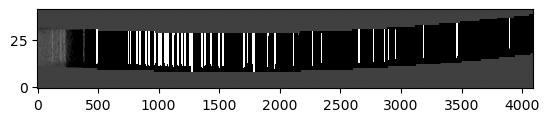

22.580763838576758


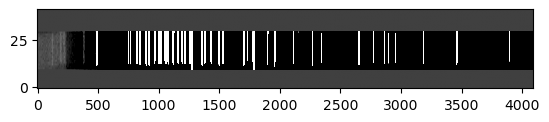

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
         x             y   labx  valley  peak
492    492   1231.000000   90.0   False  True
751    751    552.761905  136.0   False  True
756    756    407.976190  137.0   False  True
771    771    902.642857  138.0   False  True
822    822  10546.833333  143.0   False  True
847    847   9786.511905  145.0   False  True
899    899  21279.261905  152.0   False  True
925    925   5588.761905  155.0   False  True
970    970   6259.071429  161.0   False  True
974    974   2608.357143  162.0   False  True
1006  1006  19684.738095  166.0   False  True
1024  1024  22566.047619  167.0   False  True
1051  1051    212.809524  170.0   False  True
1062  1062  21854.976190  172.0   False  True
1080  1080  17985.928571  173.0   False  True
1125  1125  17485.523810  179.0   False  True
1164  1164  22255.476190  183.0   False  True
1170  1170   1358.940476  184.0   False  True
1198  1198  12080.047619  186.0   False  True
1220  1220  

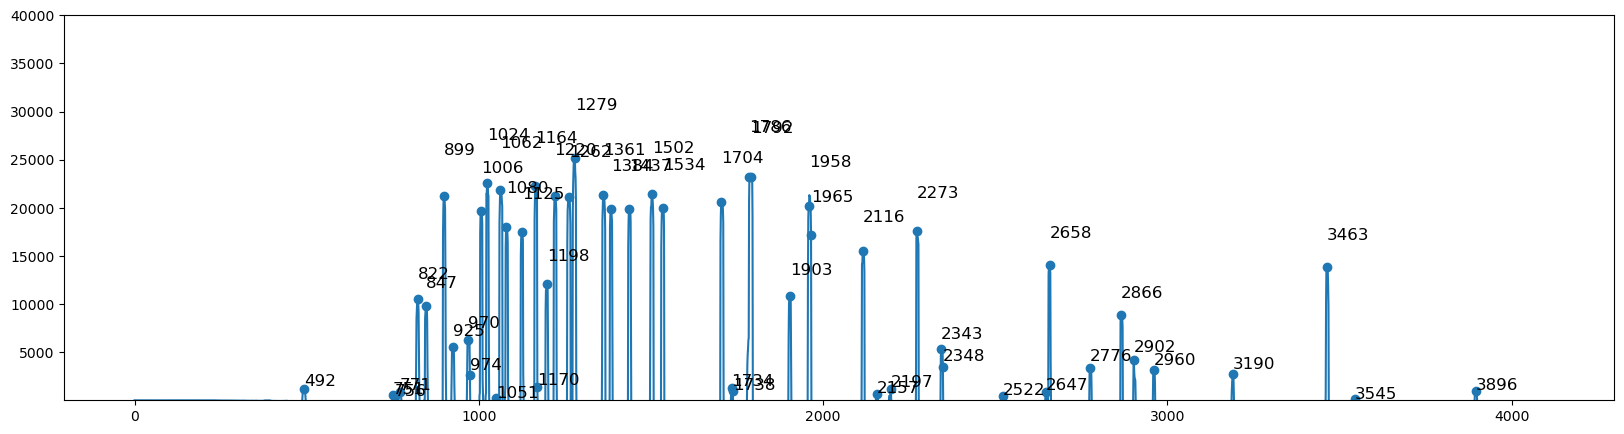

In [507]:
arc_good_slit  = lines * mask_in
arc_good_bck = lines * mask_out
plt.imshow(arc_good_slit, origin='lower', cmap='gray',vmin=-50, vmax=150,aspect='15.5') 
plt.show()

p = curvature

print(np.array(p[1,5]))

arc_good_rect = arc_good_slit * 0
for i in range(dx):
    arc_good_rect[:,i] = np.roll(arc_good_slit[:,i],-int(np.array(p[1,i]))+20)
plt.imshow(arc_good_rect,origin='lower', cmap='gray',vmin=-50, vmax=150,aspect='15.5') 
plt.show()

#fig, ax = plt.subplots()
plt.figure(figsize=(20,5))
#plt.yscale('log')
plt.ylim([10,4e4])
plt.plot(arc_good_rect.mean(axis=0))


#find the lines
#from scipy.signal import find_peaks 
import findpeaks
fp = findpeaks.findpeaks(lookahead=1)
#results = fp.fit(vector)
lines_df = fp.fit(arc_good_rect.mean(axis=0))
lines= lines_df['df'][ (lines_df['df']['peak'] == True)] 
lll = lines[lines['y'] > 100 ]
print(lll)
lll_np=lll.to_numpy()
xxx = lll.x.to_numpy()
yyy = lll.y.to_numpy()
#v_slit_up=np.delete(v_slit_up, 16, axis=0)
#print(lll_np[:,1], len(lll_np[:,1]))
#print(lines)

#ax = fig.add_subplot(1, 1, 1)
plt.scatter(xxx,yyy)
for i in range(len(xxx)):
    plt.text(xxx[i], yyy[i]*1.2, str(xxx[i]), fontsize = 12)
plt.show()

# COMPARE WITH Spectrum of target 10

Find the line corresponding to reference line and set the number to determine initial offset:

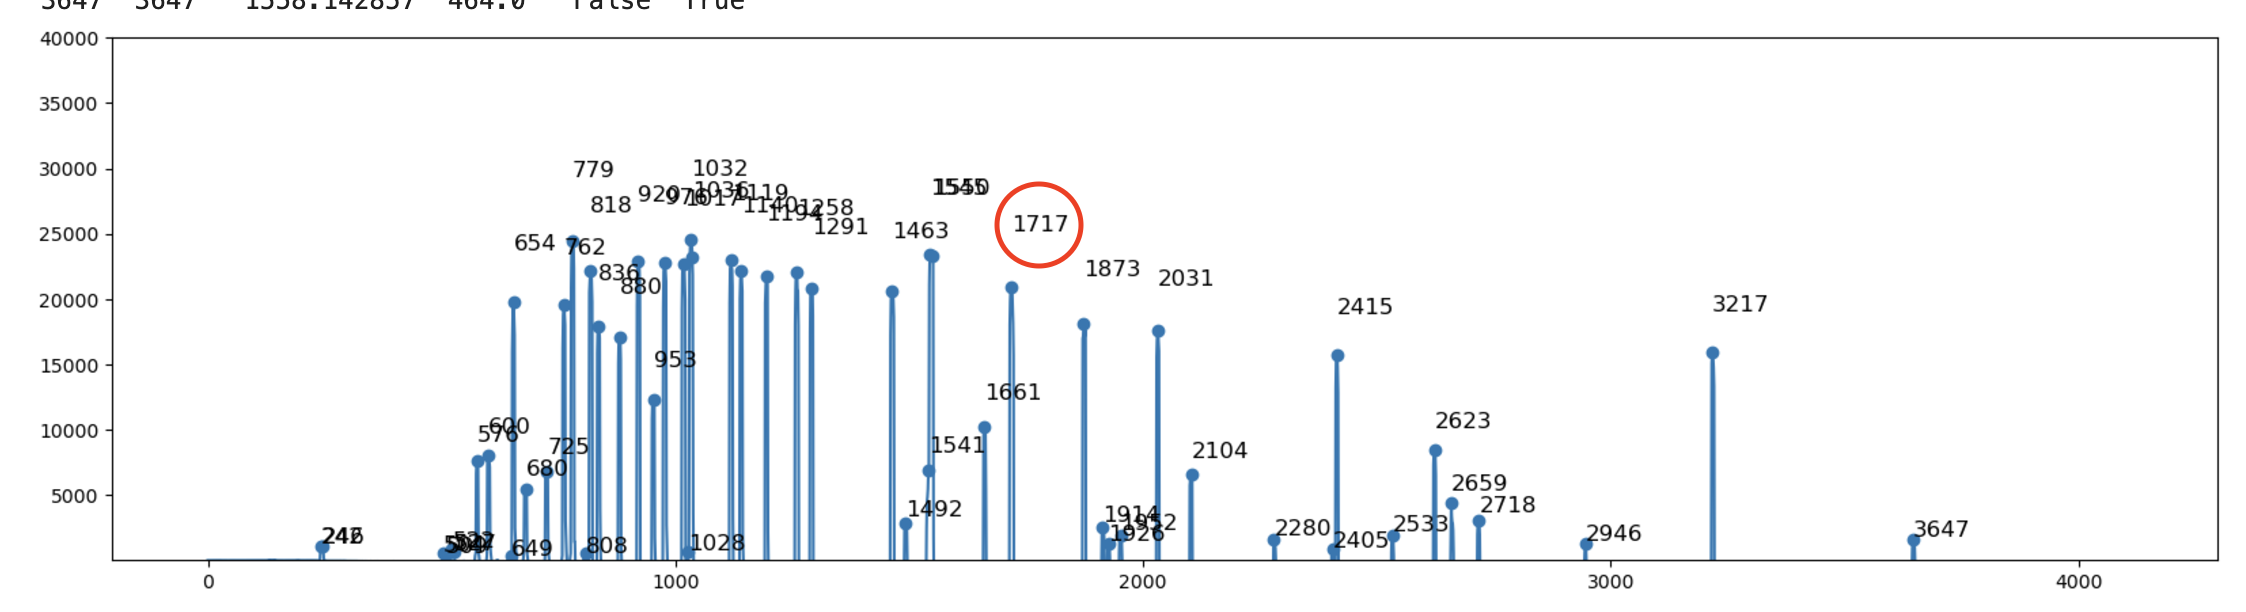

In [510]:
from IPython.display import Image
Image(filename='SAMOS_Spec10.png')

In [512]:
refline  = 1958

In [514]:
HgArNe_lam = [5460.7500,
              5769.6100,
              5790.6700, 
              5852.4879, 
              5944.8342, 
              6074.3377, 
              6096.1631, 
              6143.5939, 
              6163.5939, 
              6217.2812, 
              6266.4950,
              
              6334.4278, 
              6382.9917, 
              6402.2480, 
              6506.5281, 
              6532.8822, 
              6598.9529, 
              6678.2762, 
              6717.0430, 
              6929.4673,
              
              6965.4310, 
              7032.4131, 
              7173.9381,
              7245.1666, #24-1719
              7635.1060, #25-2031
              7724.2070, #26-2104 [Ar]
              7948.1760, #27-2280 [Ar]
              8115.3110, #28-2415 [Ar]
              8264.5220, #29-2533 [Ar]
              8377.6080, 
              8424.6480  #31-2659 [Ar]
                ]

31
31
30 31 31 

[ 4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30] [ 4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30]
899
1006
1024
1062
1080
1125
1164
1220
1262
1361
1384
1437
1502
1534
1704
1734
1786
1903
1958
2273
2343
2522
2658
2776
2866
2902
[5460.75, 5769.61, 5790.67, 5852.4879, 5944.8342, 6074.3377, 6096.1631, 6143.5939, 6163.5939, 6217.2812, 6266.495, 6334.4278, 6382.9917, 6402.248, 6506.5281, 6532.8822, 6598.9529, 6678.2762, 6717.043, 6929.4673, 6965.431, 7032.4131, 7173.9381, 7245.1666, 7635.106, 7724.207, 7948.176, 8115.311, 8264.522, 8377.608, 8424.648]
Linear Fit Coefficients: [-5.43594073e-09  4.30225146e-05  1.13778636e+00  4.89151738e+03]


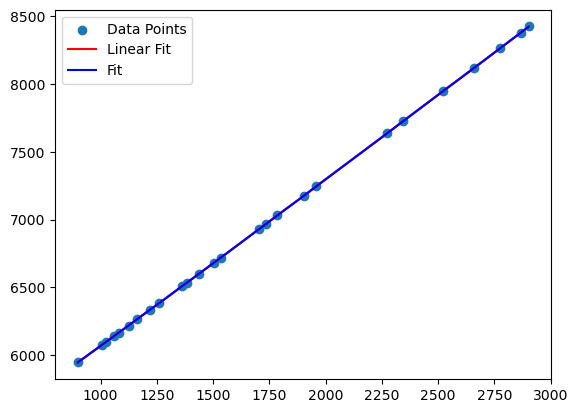

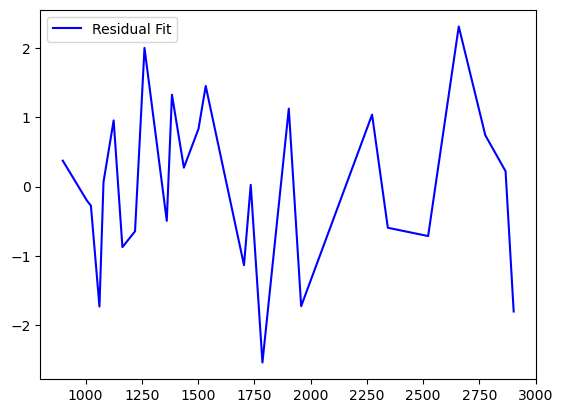

In [516]:
HgArNe_pix_0 = [246,  504, 523,   576,  654,  762,  779,  818,  836,  881,  920,  
              978, 1017, 1032, 1119, 1140, 1194, 1260, 1291, 1463, 1492, 1545, 1661, 
              1719, 2031, 2104, 2280, 2415, 2533,2623, 2659]#,2719]
print(len(HgArNe_pix_0))
OFFSET = refline - 1717  #stip 0
HgArNe_pix_0t = np.array(HgArNe_pix_0) + OFFSET
print(len(HgArNe_pix_0t))
HgArNe_pix = []
diff_pix = []
for i_lam in range(31):
#    print(i_lam)
#    print('start with a guess of where the line may be',HgArNe_pix_0t[i_lam])
    diff = HgArNe_pix_0t[i_lam]-xxx
#    print('there is a distance', diff)
    diff_pix.append(abs(diff).min())
    i_found = np.where(abs(diff) == abs(diff).min())
#    print(xxx[i_found[0][0]])
#    print('it is actually here: ',xxx[i_found[0][0]])
    HgArNe_pix.append(xxx[i_found[0][0]])
    #print(i_lam, len(HgArNe_pix),len(diff_pix))
print(i_lam, len(HgArNe_pix),len(diff_pix),'\n')
#plt.plot(HgArNe_pix,diff_pix)   
#plt.plot(HgArNe_pix[diff_pix<10],HgArNe_lam[diff_pix < 10])
dp=np.array(diff_pix)
#i_good=dp[dp<10]
i_good = np.where(dp < 5)[0]
print(i_good,np.array(i_good))
HgArNe_pix_good = []
HgArNe_lam_good = []
for i in range(len(i_good)):
    print(HgArNe_pix[i_good[i]])
    HgArNe_pix_good.append(HgArNe_pix[i_good[i]])
    HgArNe_lam_good.append(HgArNe_lam[i_good[i]])
plt.plot(HgArNe_pix_good,HgArNe_lam_good)

#coefficients = np.loadtxt(working_directory+'/wl_poly_coefficients.txt', dtype=float)
#p = np.poly1d(coefficients)
#print(p)
#HgArNe_lam = p(HgArNe_pix)

plt.scatter(HgArNe_pix_good,HgArNe_lam_good, label='Data Points')
plt.plot(HgArNe_pix_good, HgArNe_lam_good, label='Linear Fit', color='red')
plt.legend()

print(HgArNe_lam)

coefficients = np.polyfit(HgArNe_pix_good,HgArNe_lam_good, 3)
print("Linear Fit Coefficients:", coefficients)

# Create polynomial function
p = np.poly1d(coefficients)

plt.plot(HgArNe_pix_good, p(HgArNe_pix_good), label='Fit', color='blue')
plt.legend()
plt.show()

plt.plot(HgArNe_pix_good, p(HgArNe_pix_good)-HgArNe_lam_good, label='Residual Fit', color='blue')
plt.legend()
plt.show()

## Parenthesis to save and reload the polynomial coeefficients

In [519]:
print(coefficients,p)
print(working_directory)
np.savetxt(working_directory+'/wl_poly_coefficients_{i_slit:03.0f}.txt'.format(i_slit=i_slit), coefficients)
coefficients_in = np.loadtxt(working_directory+'/wl_poly_coefficients_{i_slit:03.0f}.txt'.format(i_slit=i_slit), dtype=float)
print(coefficients_in)
coefficients ==  coefficients_in



[-5.43594073e-09  4.30225146e-05  1.13778636e+00  4.89151738e+03]             3             2
-5.436e-09 x + 4.302e-05 x + 1.138 x + 4892
/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS/ABELL3120_manual_Mask_T00_Low_Red
[-5.43594073e-09  4.30225146e-05  1.13778636e+00  4.89151738e+03]


array([ True,  True,  True,  True])

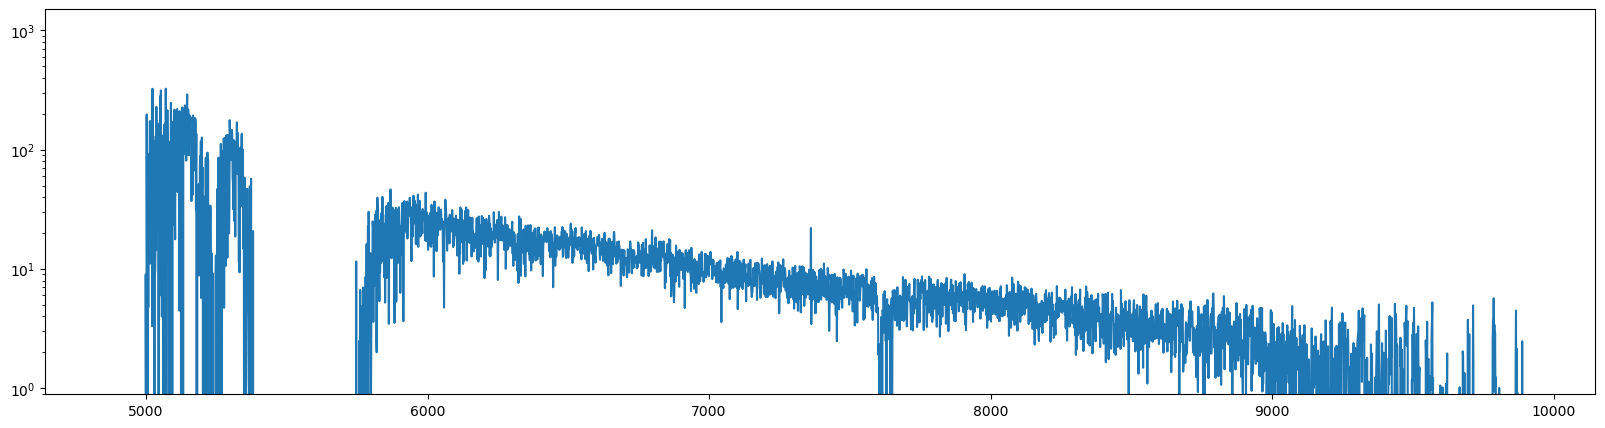

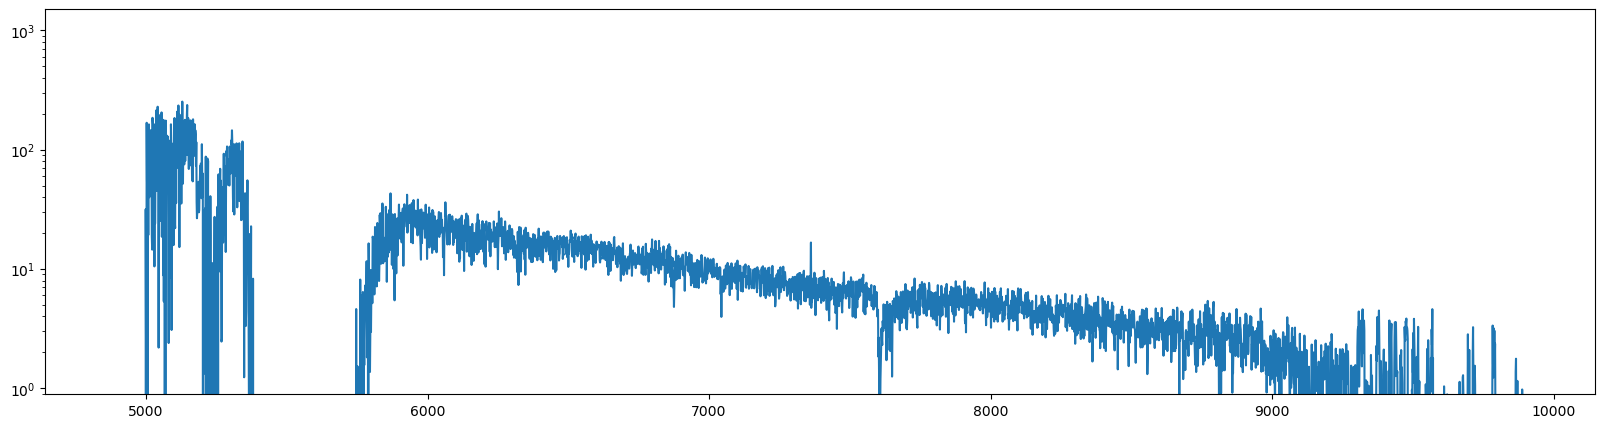

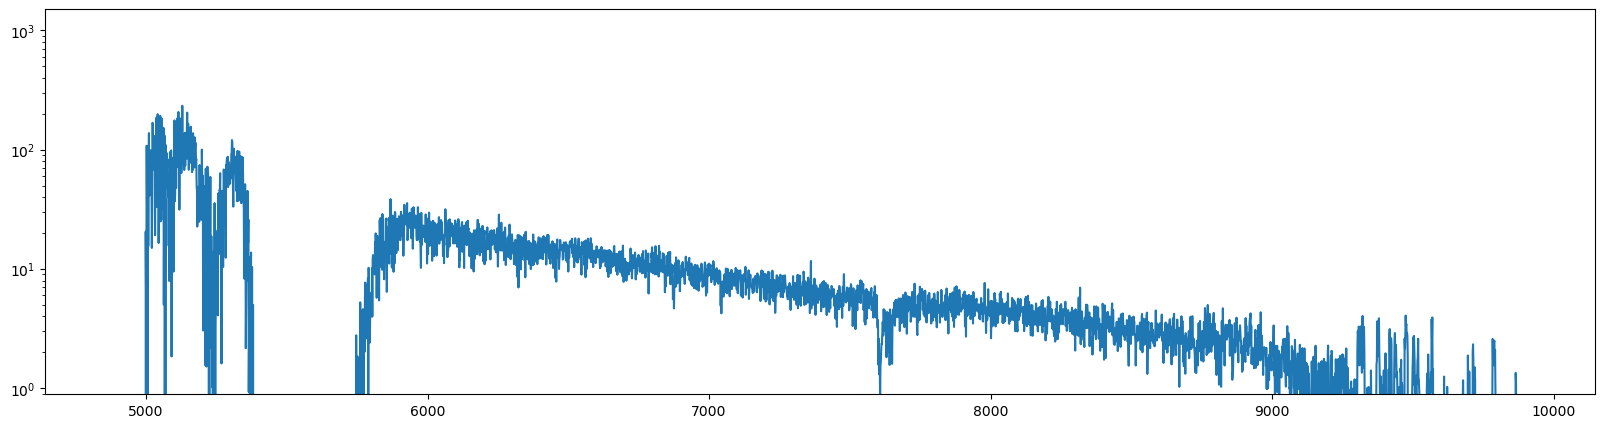

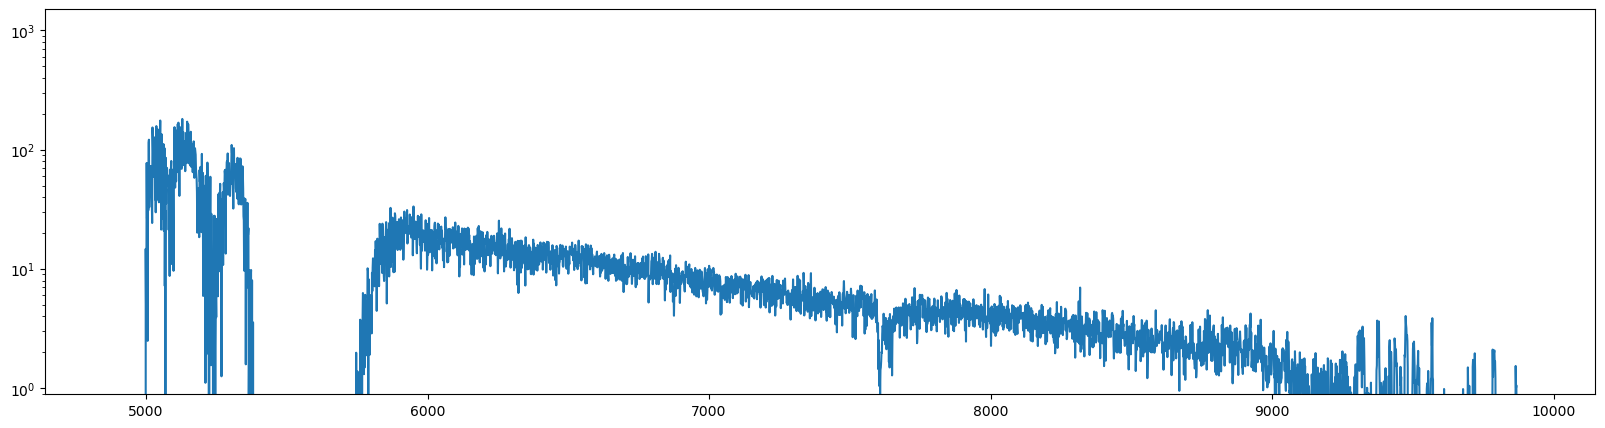

In [521]:
x=np.arange(dx)
wl = p(x)
xc = 20#(slits[i][2]+slits[i][1])/2.
#spectrum_1d = spectra_slit_ff_rect_OH[17:25,:].mean(axis=0)
for dist in range(4):
    plt.figure(figsize=(20,5))
    plt.yscale('log')
    plt.ylim([0,1500])
    spectrum_1d = spec_2d[22-dist:23+dist,:].mean(axis=0)
    plt.plot(wl,spectrum_1d) 
    plt.show()

In [522]:
#====================================================================================
fits_file = working_directory+'/spec_{i_s:03.0f}.fits'.format(i_s=i_slit)
hdulist = fits.open(fits_file)

hdulist[0].header['l_7245A'] = refline     # line 7245.1666A at 1717
#add wl 
obj = hdulist.pop('SPEC-1D')
spec1d = [wl,spectrum_1d]
final1d_hdu = fits.ImageHDU(data=spec1d, name= "SPEC-1d")
hdulist.append(final1d_hdu)

    
hdulist.info()
hdulist.writeto(working_directory+'/spec_{i_s:03.0f}.fits'.format(i_s=i_slit),overwrite=True)
hdulist.close()

Filename: /Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS/ABELL3120_manual_Mask_T00_Low_Red/spec_013.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   ()      
  1  DATA          1 ImageHDU         8   (4094, 42)   float64   
  2  FLAT          1 ImageHDU         8   (4094, 42)   float64   
  3  LINES         1 ImageHDU         8   (4094, 42)   float64   
  4  MASK          1 ImageHDU         8   (4094, 42)   float64   
  5  COEFFS        1 ImageHDU         7   (4,)   float64   
  6  CURVATURE     1 ImageHDU         8   (4094, 2)   float64   
  7  SPEC-2D       1 ImageHDU         8   (4094, 42)   float64   
  8  SPEC-1D       1 ImageHDU         8   (4094, 2)   float64   


4093
[5800.19615726 5801.39104612 5802.58599561 ... 9892.83268965 9894.04957761
 9895.26641819] Angstrom
[5800.19615726 5801.39104612 5802.58599561 ... 9892.83268965 9894.04957761
 9895.26641819] Angstrom
/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS/ABELL3120_manual_Mask_T00_Low_Red/spec2d_013.fits


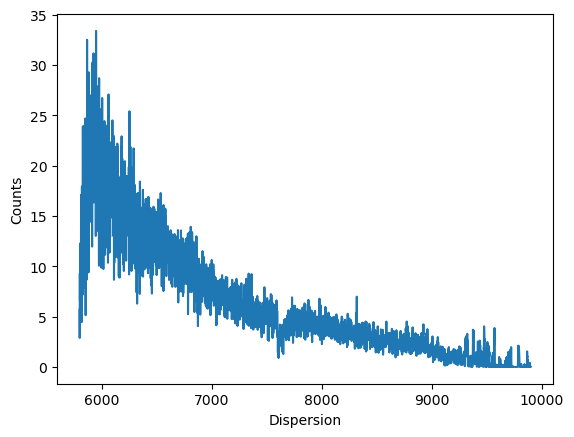

In [525]:
flux = spectrum_1d * u.adu
wavelength = wl * u.AA
#imin = np.where(a.find(a>2)
diff_0 = abs(wavelength-5800*u.AA)                
i_0 = np.where(diff_0 == min(diff_0))[0][0]
diff_1 = abs(wavelength-10000*u.AA)                
i_1 = np.where(diff_1 == min(diff_1))[0][0]
print(i_1)
print(wavelength[i_0:i_1])
#wavelength_band = np.arange(wavelength, 10000) * u.AA
spec1d = Spectrum1D(spectral_axis=wavelength[i_0:i_1], flux=flux[i_0:i_1])
ax = plt.subplots()[1]  
ax.plot(spec1d.spectral_axis, spec1d.flux)  
ax.set_xlabel("Dispersion")  
ax.set_ylabel("Counts")  

print(spec1d.spectral_axis)
#to write
spec1d.write(working_directory+'/spec1d_{i_slit:03.0f}.fits'.format(i_slit=i_slit),overwrite=True)  
#to read
spec1d = Spectrum1D.read(working_directory+'/spec1d_{i_slit:03.0f}.fits'.format(i_slit=i_slit))  


hdul = fits.open(fits_file)
spec_2d_data = hdul[7].data  
spec2d = Spectrum1D(spectral_axis=wavelength[i_0:i_1],
                    flux = spec_2d_data[:,i_0:i_1]*u.adu)
hdul.close
spec2d.write(working_directory+'/spec2d_{i_slit:03.0f}.fits'.format(i_slit=i_slit),overwrite=True)  
print(working_directory+'/spec2d_{i_slit:03.0f}.fits'.format(i_slit=i_slit))


In [527]:
### SAVE THE 1D and 2D files

In [529]:
spec1d = Spectrum1D.read(working_directory+'/spec1d_{i_slit:03.0f}.fits'.format(i_slit=i_slit))  
wl = np.array(spec1d.wavelength/u.AA)
fl = np.array(spec1d.flux/u.adu)
lambda_spec= np.row_stack((wl, fl))
#lambda_spec = [np.array(spec1d.wavelength/u.AA),np.array(spec1d.flux/u.adu)]
lambda_spec.shape
# Save the matrix to a text file
spec1d_txt= working_directory+'/spec1d_{i_slit:03.0f}.txt'.format(i_slit=i_slit)
with open(spec1d_txt, 'w') as f:
    for i in range(len(wl)):    
        f.write('{wl:5.0f}   {fl:7.2f}\n'.format(wl=wl[i],fl=fl[i]))    
#np.savetxt(spec1d_txt, lambda_spec, delimiter=',') 



# GET THE SPECTRA FOR THE OTHER LAMPS
# LEFT AS AN EXERCISE


In [427]:
#inverse solution
coefficients_1 = np.polyfit(HgArNe_lam,HgArNe_pix, 3)
print("Linear Fit Coefficients:", coefficients_1)

# Create polynomial function
p_1 = np.poly1d(coefficients_1)


Ar_lines = [696.54, 706.72, 714.70, 727.20, 738.40, 750.39, 763.51, 772.38, 794.82, 811.53,]
Hg_lines = [253.65, 296.73, 302.15, 313.16, 334.15,	404.66, 365.02, 407.78, 435.83,	546.07,	576.96,	579.07]
HgAr_lam= [6965.431, 7067.218, 7147.042, 7272.936, 7383.980, 7503.869, 7514.652, 7635.106, 7723.761, 7948.176,  8006.157, 8014.786, 8103.6930, 8115.3110,  8264.5, 8424.7, 8521.4, 8668.0, 9123.0, 9225.0]
#Ne_lines = 
print(p_1(HgAr_lam))


Linear Fit Coefficients: [ 2.00261450e-09 -5.03709257e-05  1.21946788e+00 -5.06749052e+03]
[1659.54146362 1741.82551727 1806.23946202 1907.63946938 1996.90226076
 2093.10923082 2101.75447278 2198.24904082 2269.18511708 2448.48802075
 2494.76528177 2501.65111509 2572.57993006 2581.84646609 2700.80771418
 2828.51443281 2905.60370925 3022.50625017 3385.97051595 3467.66243053]



## APPENDIX: BUILDING THE P-FLATS

Pixel flats are obtained when two flats of different brightness (e.g. exposure time) are bias subtracted and then divided; 
after division by the ration of the exposure times, the image should be around 1 average, with salt-pepper noise indicative of the relative response of the pixels. To be repeated multiple times to beat down the readnoise.

We run thi experiment on the first night, and the format of the image was later changed so these are not useful for processing data taken later.

In [ ]:
#FIRST STEP: READ AND MOVE THE FILES
File_type = "FLAT QUARTZ"
File_NR = '019'
file_01  = os.path.join(data_directory_09,'flat.'+File_NR+'.fits')
print(file_01)

File_NR = '020'
file_10  = os.path.join(data_directory_09,'flat.'+File_NR+'.fits')
print(file_10)

File_type = "FLAT QUARTZ"
File_NR = '041'
file_bias  = os.path.join(data_directory_09,'flat.'+File_NR+'.fits')
print(file_bias)


#SECOND STEP: READ AND AVERAGE
hdu = SAMOS.read_SAMI_mosaic(file_01)
flat_01_data = hdu.data
hdu.data = flat_01_data

hdu1 = SAMOS.read_SAMI_mosaic(file_10)
flat_10_data = hdu1.data
hdu1.data = flat_10_data

hdu1 = SAMOS.read_SAMI_mosaic(file_bias)
bias_data = hdu1.data
hdu1.data = bias_data

flat_01_data_bias = flat_01_data - bias_data
flat_10_data_bias = flat_10_data - bias_data
flat = np.divide(flat_10_data_bias,flat_01_data_bias,out=np.full_like(flat_10_data_bias, 10), where=flat_01_data_bias!=0 )/10.
print(flat.shape)

#DISPLAY
image = flat
median = np.median(flat)
stddev = np.std(flat)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(flat,zmin=z0,zmax=z1)